In [76]:
import pandas
from econml.metalearners import XLearner
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
import numpy as np
from tqdm import tqdm

## Prepare the data

In [77]:
from sklearn.model_selection import train_test_split

np.random.seed(123)

df = pandas.read_csv('../data/train_new.csv')
df = df.sample(frac = 0.01)

df["not_random_bool"] = 1 - df['random_bool']

train_data = df.sample(frac = 0.7)
test_data = df.drop(train_data.index)
x_vars = ['visitor_hist_starrating', 'visitor_hist_adr_usd',
              'prop_starrating', 'prop_review_score', 'prop_brand_bool', 
              'prop_location_score1', 'prop_log_historical_price', 'price_usd',
              'promotion_flag', 'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count',
              'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool', 'orig_destination_distance']
t_var = ["not_random_bool"]
y_vars = ['booking_bool', 'click_bool']

X_train = train_data.loc[:, x_vars].to_numpy()
Y_train = train_data.loc[:, y_vars].to_numpy()  # N x 2
T_train = train_data.loc[:, t_var].to_numpy()

X_test = test_data.loc[:, x_vars].to_numpy()
Y_test = test_data.loc[:, y_vars].to_numpy()
T_test = test_data.loc[:, t_var].to_numpy()

In [78]:
# from sklearn.model_selection import train_test_split
# X_np = X.to_numpy(na_value=0)
# Y_np = Y.to_numpy()
# T_np = T.to_numpy()
# data = np.concatenate((X_np, Y_np, T_np[..., None]), axis=-1)
# n_data = data.shape[0]
# train_data, test_data = train_test_split(data[:int(n_data * 0.01)], train_size=0.7)
# X_train = train_data[:, :-3]
# Y_train = train_data[:, -3:-1]  # N x 2
# T_train = train_data[:, -1]

# X_test = test_data[:, :-3]
# Y_test = test_data[:, -3:-1]
# T_test = test_data[:, -1]

## Train the models

In [79]:
# XLearner
xlearners = []
for i in tqdm(range(Y_train.shape[1])):
    xlearner = XLearner(models=GradientBoostingRegressor(),
                propensity_model=GradientBoostingClassifier(),
                cate_models=GradientBoostingRegressor())
    xlearner.fit(Y_train[:, i], T_train, X=X_train)
    xlearners.append(xlearner)

100%|██████████| 2/2 [00:59<00:00, 29.70s/it]


In [80]:
HTEs_xlearner = []
ATEs_xlearner = []
for i in tqdm(range(Y_train.shape[1])):
    HTE_xlearner = xlearners[i].effect(X_test)
    ATE_xlearner = xlearners[i].ate(X_test)
    HTEs_xlearner.append(HTE_xlearner)
    ATEs_xlearner.append(ATE_xlearner)

100%|██████████| 2/2 [00:00<00:00,  3.48it/s]


In [81]:
HTEs_xlearner, ATEs_xlearner

([array([0.04671599, 0.0311561 , 0.03266398, ..., 0.0289962 , 0.03785484,
         0.02582982]),
  array([ 0.00257943, -0.01459384, -0.00624698, ..., -0.01252184,
          0.00061201, -0.00887632])],
 [0.02879981306798696, -0.006393766184045284])

In [82]:
'''
# Fit with bootstrap confidence interval construction enabled
xlearner.fit(Y_train, T_train, X=X_train, inference='bootstrap')
TE_xlearner = xlearner.effect(X_test)
lb, ub = xlearner.effect_interval(X_test, alpha=0.05) # Bootstrap CIs
TE_xlearner, lb, ub
'''

"\n# Fit with bootstrap confidence interval construction enabled\nxlearner.fit(Y_train, T_train, X=X_train, inference='bootstrap')\nTE_xlearner = xlearner.effect(X_test)\nlb, ub = xlearner.effect_interval(X_test, alpha=0.05) # Bootstrap CIs\nTE_xlearner, lb, ub\n"

In [106]:
# TLearner
from econml.metalearners import TLearner
from sklearn.linear_model import LinearRegression

tlearners = []
for i in tqdm(range(Y_train.shape[1])):
    tlearner = TLearner(models=LinearRegression())
    tlearner.fit(Y_train[:, i], T_train, X=X_train)
    tlearners.append(tlearner)

100%|██████████| 2/2 [00:00<00:00,  5.49it/s]


In [107]:
HTEs_tlearner = []
ATEs_tlearner = []
for i in tqdm(range(Y_train.shape[1])):
    HTE_tlearner = tlearners[i].effect(X_test)
    ATE_tlearner = tlearners[i].ate(X_test)
    HTEs_tlearner.append(HTE_tlearner)
    ATEs_tlearner.append(ATE_tlearner)

100%|██████████| 2/2 [00:00<00:00,  8.15it/s]


In [85]:
# SLearner
from econml.metalearners import SLearner
from sklearn.ensemble import RandomForestRegressor

slearner = SLearner(overall_model=RandomForestRegressor())
slearner.fit(Y_train, T_train, X=X_train, inference='bootstrap')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

In [86]:
HTE_slearner = slearner.effect(X_test)
ATE_slearner = slearner.ate(X_test)
HTE_slearner, ATE_slearner 

(array([[ 0.02,  0.02],
        [-0.01, -0.06],
        [ 0.06,  0.02],
        ...,
        [ 0.01,  0.  ],
        [ 0.03,  0.03],
        [ 0.01,  0.  ]]),
 array([ 0.03772157, -0.00828253]))

In [87]:
# DRLearner
from econml.dr import DRLearner
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

drlearners = []
for i in tqdm(range(Y_train.shape[1])):
    drlearner = DRLearner(model_propensity=RandomForestClassifier(n_estimators=100, min_samples_leaf=10), 
                        model_regression=RandomForestRegressor(n_estimators=100, min_samples_leaf=10),
                        model_final=LassoCV(cv=3),
                        random_state=0)
    drlearner.fit(Y_train[:, i], T_train, X=X_train, W=None)
    drlearners.append(drlearner)

100%|██████████| 2/2 [01:53<00:00, 56.95s/it]


In [88]:
HTEs_drlearner = []
ATEs_drlearner = []
for i in tqdm(range(Y_train.shape[1])):
    HTE_drlearner = drlearners[i].effect(X_test)
    ATE_drlearner = drlearners[i].ate(X_test)
    HTEs_drlearner.append(HTE_drlearner)
    ATEs_drlearner.append(ATE_drlearner)

HTEs_drlearner, ATEs_drlearner

100%|██████████| 2/2 [00:00<00:00,  7.80it/s]


([array([0.03382096, 0.02847685, 0.03702516, ..., 0.03509613, 0.02744764,
         0.02318066]),
  array([-0.0070942, -0.0070942, -0.0070942, ..., -0.0070942, -0.0070942,
         -0.0070942])],
 [0.02838255264029301, -0.007094203803147595])

In [89]:
# DML
from econml.dml import DML
from econml.sklearn_extensions.linear_model import StatsModelsLinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

dml = DML(model_y=RandomForestRegressor(),
          model_t=RandomForestClassifier(),
          model_final=StatsModelsLinearRegression(fit_intercept=False), 
          linear_first_stages=False, 
          discrete_treatment=True,
          random_state=0)

dml.fit(Y_train, T_train, X=X_train)

In [90]:
HTE_dml = dml.effect(X_test)
ATE_dml = dml.ate(X_test)

HTE_dml, ATE_dml

(array([[ 0.03460547, -0.00635932],
        [ 0.02502573, -0.0136955 ],
        [ 0.03926619, -0.00538238],
        ...,
        [ 0.03505775, -0.00638717],
        [ 0.02269832, -0.01060266],
        [ 0.01931225, -0.00794567]]),
 array([ 0.02615793, -0.00937034]))

In [91]:
#Causal Forest

from econml.dml import CausalForestDML
from sklearn.linear_model import LassoCV

cfs = []
for i in tqdm(range(Y_train.shape[1])):
    # Or specify hyperparameters
    cf = CausalForestDML(criterion='het', n_estimators=500,       
                        min_samples_leaf=10, 
                        max_depth=10, max_samples=0.5,
                        discrete_treatment=False,
                        model_t=LassoCV(), model_y=LassoCV())
    cf.fit(Y_train[:, i], T_train, X=X_train, W=None)
    cfs.append(cf)

# # Confidence intervals via Bootstrap-of-Little-Bags for forests
# lb, ub = est.effect_interval(X_test, alpha=0.05)

  0%|          | 0/2 [00:00<?, ?it/s]A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 50%|█████     | 1/2 [00:35<00:35, 35.41s/it]A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
100%|██████████| 2/2 [01:13<00:00, 36.62s/it]


In [92]:
HTEs_cf = []
ATEs_cf = []
for i in tqdm(range(Y_train.shape[1])):
    HTE_cf = cfs[i].effect(X_test)
    ATE_cf = cfs[i].ate(X_test)
    HTEs_cf.append(HTE_cf)
    ATEs_cf.append(ATE_cf)

HTEs_cf, ATEs_cf

100%|██████████| 2/2 [00:09<00:00,  4.84s/it]


([array([0.04840049, 0.03220481, 0.04167054, ..., 0.03188913, 0.03359293,
         0.02577329]),
  array([ 0.00174298, -0.01040253, -0.00452216, ..., -0.01311926,
         -0.00164631, -0.00163913])],
 [0.029935807821416468, -0.004650906905276374])

In [93]:
#Orthogonal Random Forest, takes too long for prediction, skipped

# from econml.orf import DMLOrthoForest, DROrthoForest
# from econml.sklearn_extensions.linear_model import WeightedLasso, WeightedLassoCV

# ORFs= []
# for i in tqdm(range(Y_train.shape[1])):
#     est = DMLOrthoForest(n_trees=500, min_leaf_size=10,
#                         max_depth=10, subsample_ratio=0.7,
#                         lambda_reg=0.01,
#                         discrete_treatment=False,
#                         model_T=WeightedLasso(alpha=0.01), model_Y=WeightedLasso(alpha=0.01),
#                         model_T_final=WeightedLassoCV(cv=3), model_Y_final=WeightedLassoCV(cv=3))
#     est.fit(Y_train[:, i], T_train, X=X_train, W=None)
#     ORFs.append(est)

# HTEs_ORF = []
# ATEs_ORF = []
# for i in tqdm(range(Y_train.shape[1])):
#     HTE_ORF = ORFs[i].effect(X_test)
#     ATE_ORF = ORFs[i].ate(X_test)
#     HTEs_ORF.append(HTE_ORF)
#     ATEs_ORF.append(ATE_ORF)

# HTEs_ORF, ATEs_ORF

In [126]:
# Basline: fully interacted linear regression
from toolz import curry
import statsmodels.formula.api as smf
import statsmodels.api as sm


lrs = []

lrs.append(smf.ols("booking_bool ~ not_random_bool + not_random_bool*visitor_hist_starrating + not_random_bool*visitor_hist_adr_usd + not_random_bool*prop_starrating + not_random_bool*prop_review_score + not_random_bool*prop_brand_bool + not_random_bool*prop_location_score1 + not_random_bool*prop_log_historical_price + not_random_bool*price_usd + not_random_bool*promotion_flag + not_random_bool*srch_length_of_stay + not_random_bool*srch_booking_window + not_random_bool*srch_adults_count + not_random_bool*srch_children_count + not_random_bool*srch_room_count + not_random_bool*srch_saturday_night_bool + not_random_bool*orig_destination_distance", data = train_data).fit())


lrs.append(smf.ols("click_bool ~ not_random_bool + not_random_bool*visitor_hist_starrating + not_random_bool*visitor_hist_adr_usd + not_random_bool*prop_starrating + not_random_bool*prop_review_score + not_random_bool*prop_brand_bool + not_random_bool*prop_location_score1 + not_random_bool*prop_log_historical_price + not_random_bool*price_usd + not_random_bool*promotion_flag + not_random_bool*srch_length_of_stay + not_random_bool*srch_booking_window + not_random_bool*srch_adults_count + not_random_bool*srch_children_count + not_random_bool*srch_room_count + not_random_bool*srch_saturday_night_bool + not_random_bool*orig_destination_distance", data = train_data).fit())

HTEs_lr = []
for model in lrs:
    HTEs_lr.append((model.predict(test_data.assign(not_random_bool=1))-model.predict(test_data.assign(not_random_bool=0))).values)


## Evaluation

In [95]:
import matplotlib.pyplot as plt

@curry
def cate(data, y, t):
        # line coeficient for the one variable linear regression 
        return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
                np.sum((data[t] - data[t].mean())**2))


def cumulative_cate_curve(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    
    # orders the dataset by the `prediction` column
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    
    # create a sequence of row numbers that will define our Ks
    # The last item is the sequence is all the rows (the size of the dataset)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    # cumulative computes the elasticity. First for the top min_periods units.
    # then for the top (min_periods + step*1), then (min_periods + step*2) and so on
    return np.array([cate(ordered_df.head(rows), y, t) for rows in n_rows])

In [129]:
test_data = test_data.assign(
    booking_cate_pred_xlearner = HTEs_xlearner[0],
    booking_cate_pred_tlearner =  HTEs_tlearner[0],
    booking_cate_pred_slearner = HTE_slearner[:,0],
    booking_cate_pred_drlearner = HTEs_drlearner[0], 
    booking_cate_pred_dml = HTE_dml[:,0],
    booking_cate_pred_cf = HTEs_cf[0], 
    booking_cate_pred_lr = HTEs_lr[0],
    click_cate_pred_xlearner = HTEs_xlearner[1],
    click_cate_pred_tlearner =  HTEs_tlearner[1],
    click_cate_pred_slearner = HTE_slearner[:,1],
    click_cate_pred_drlearner = HTEs_drlearner[1], 
    click_cate_pred_dml = HTE_dml[:,1],
    click_cate_pred_cf = HTEs_cf[1], 
    click_cate_pred_lr = HTEs_lr[1],
    
)


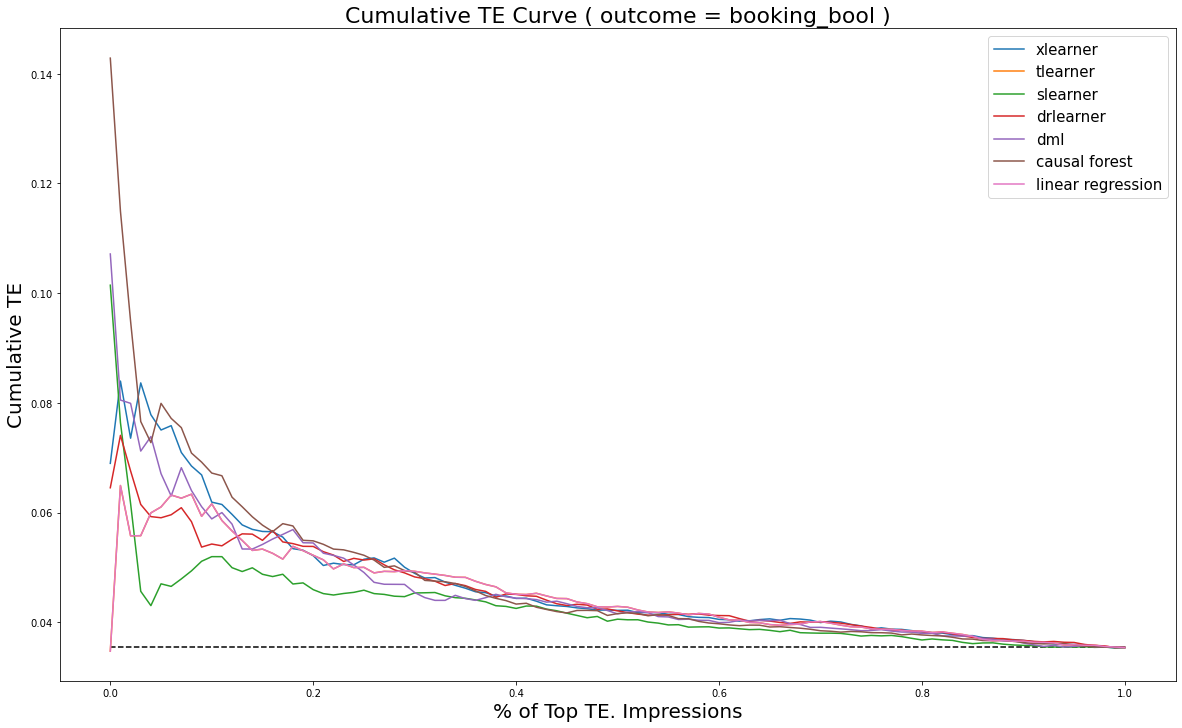

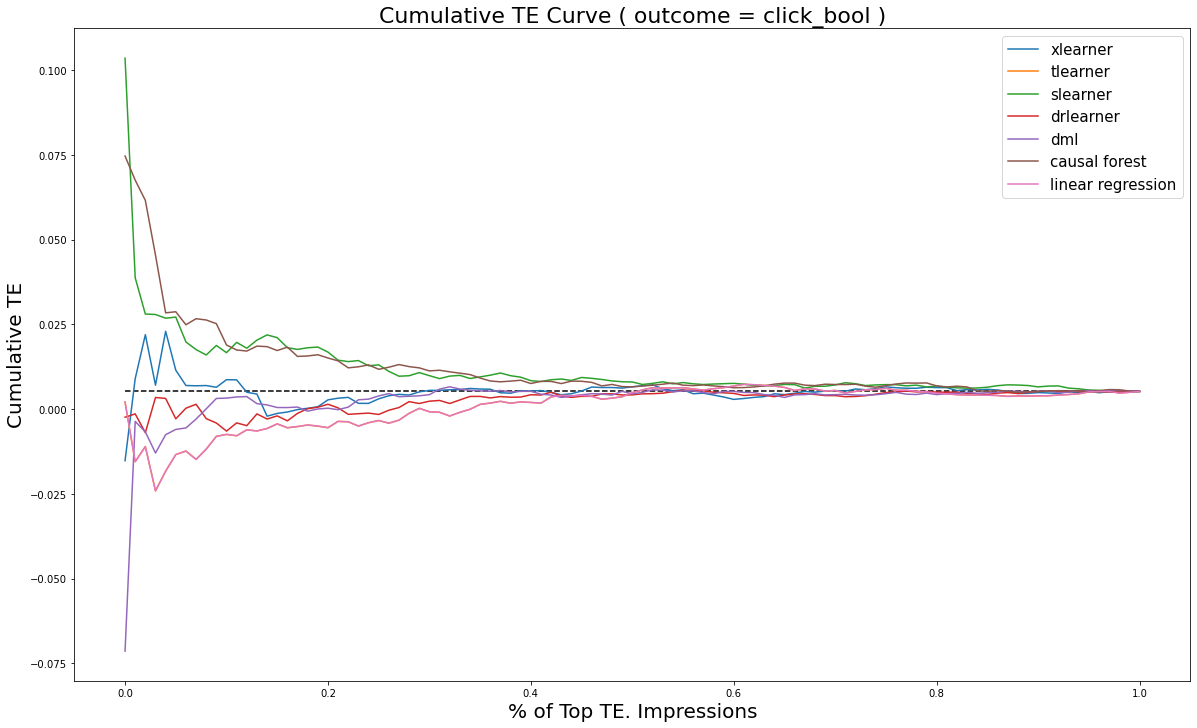

In [141]:
model_names = ["xlearner","tlearner","slearner","drlearner","dml","cf","lr"]
for y_var in ["booking_bool", "click_bool"]:
    plt.figure(figsize=(20,12))
    for m in [y_var[:-5]+"_cate_pred_"+model_n for model_n in model_names]:
        cumu_cate = cumulative_cate_curve(test_data, m, y_var, "not_random_bool", min_periods=100, steps=100)
        x = np.array(range(len(cumu_cate)))
        plt.plot(x/x.max(), cumu_cate, label=m)

    plt.hlines(cate(test_data, y_var, "not_random_bool"), 0, 1, linestyles="--", color="black", label="Avg. TE.")
    plt.xlabel("% of Top TE. Impressions", fontsize=20)
    plt.ylabel("Cumulative TE", fontsize=20)
    plt.title("Cumulative TE Curve ( outcome = "+y_var+" )", fontsize=22)
    plt.legend( ["xlearner","tlearner","slearner","drlearner","dml","causal forest","linear regression"], prop={'size': 15});